In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!ls

In [10]:
%%bash
set -m
git clone https://github.com/sachdevkartik/DeepLense.git
cd DeepLense && git checkout kartik_contribution
cd ..
mv DeepLense/Transformers_Classification_DeepLense_Kartik_Sachdev/* .
rm -rf DeepLense

Cloning into 'DeepLense'...
Switched to a new branch 'kartik_contribution'


Branch 'kartik_contribution' set up to track remote branch 'kartik_contribution' from 'origin'.


mv: cannot move 'DeepLense/Transformers_Classification_DeepLense_Kartik_Sachdev/models' to './models': Directory not empty


In [11]:
%%bash
pip3 install --upgrade lightly einops vit-pytorch>=0.27.0 seaborn>=0.11.0 ipython thop gdown split-folders  protobuf==3.20.* e2cnn==0.1.9


# scikit-learn 
# opencv-python>=4.1.1 Pillow>=8.2.0 PyYAML>=5.3.1

In [ ]:
# ray[tune] \
# ray[air] \


In [ ]:
# !pip uninstall -y numpy

In [ ]:
# !pip install numpy

In [12]:
from __future__ import print_function
import os
import time
import copy
import json
import yaml

import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision
from typing import *

In [13]:
from utils.util import *
from config.data_config import DATASET
from utils.dataset import DefaultDatasetSetupSSL
from self_supervised.losses.contrastive_loss import (
    ContrastiveLossEuclidean,
    ContrastiveLossEmbedding,
    SimCLR_Loss,
    NegativeCosineSimilarity,
)
from self_supervised.losses.sym_neg_cos_sim_loss import SymNegCosineSimilarityLoss

from models.modules.head import BYOLProjectionHead, BYOLPredictionHead
from utils.scheduler import cosine_schedule
from torch.utils.data import DataLoader, random_split
from einops.layers.torch import Rearrange
from config.cvt_config import CvT_CONFIG
from models.transformer_zoo import TransformerModels
import math
from transformers import get_cosine_schedule_with_warmup
from utils.inference import InferenceSSL

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [14]:
batch_size = 64
dataset_name = "Model_II"
dataset_dir = "/kaggle/input/gsocml4scimodel2"
use_cuda = True
num_workers = 3

log_dir_base = "logger"
extracted_dir = "/kaggle/input/gsocml4scimodel2/Model_II"
classes = DATASET[f"{dataset_name}"]["classes"]
num_classes = len(classes)

In [15]:
train_config = CvT_CONFIG
learning_rate = train_config["optimizer_config"]["lr"]
num_channels = train_config["channels"]
network_type = train_config["network_type"]
image_size = train_config["image_size"]
optimizer_config = train_config["optimizer_config"]

make_directories([dataset_dir, extracted_dir])
seed_everything(seed=42)

In [16]:
# logging
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir = f"{log_dir_base}/{current_time}"
init_logging_handler(log_dir_base, current_time)

# dump config in logger
with open(f"{log_dir}/config.json", "w") as fp:
    json.dump(train_config, fp)

In [17]:
# paths
model_path_pretrained = "/kaggle/working/logger/2023-08-09-21-09-16/checkpoint/CvT_pretrained_Model_II_2023-08-09-21-09-16.pt" # incase of pretrained 

# model_path_pretrained = os.path.join(
#     f"{log_dir}/checkpoint",
#    f"{network_type}_pretrained_{dataset_name}_{current_time}.pt",
# )

finetuned_model_path = os.path.join(
    f"{log_dir}/checkpoint",
    f"{network_type}_finetune_{dataset_name}_{current_time}.pt",
)

# finetuned_model_path = os.path.join("/kaggle/working/logger/2023-08-09-21-09-16/checkpoint", f"CvT_dino_finetuned_{dataset_name}_{current_time}.pt")

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


class DINOTransform:
    """Implements the global and local view augmentations for DINO [0].
    """

    def __init__(self):
        pass
    
    def get_transforms(self, 
                       global_crop_size: int = 224,
                       global_crop_scale: Tuple[float, float] = (0.4, 1.0),
                       local_crop_size: int = 96,
                       local_crop_scale: Tuple[float, float] = (0.05, 0.4),):

        # first global crop
        global_transform_0 = A.Compose(
        [
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            A.Resize(global_crop_size, global_crop_size, p=1.0),
            A.augmentations.GaussianBlur(),
            ToTensorV2(),
        ])

        # second global crop
        global_transform_1 = A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.25),
            A.Resize(global_crop_size, global_crop_size, p=1.0),
            A.augmentations.GaussNoise(var_limit=(0.002, 0.005), p=0.3),
            ToTensorV2(),
        ])
        
        # transformation for the local small crops
        local_transform = A.Compose(
        [
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            A.Resize(local_crop_size, local_crop_size, p=1.0),
            A.augmentations.GaussianBlur(),
            ToTensorV2(),
        ])
        return [global_transform_0, global_transform_1, local_transform]
    

Model_II dataset already exists
train data: 89104


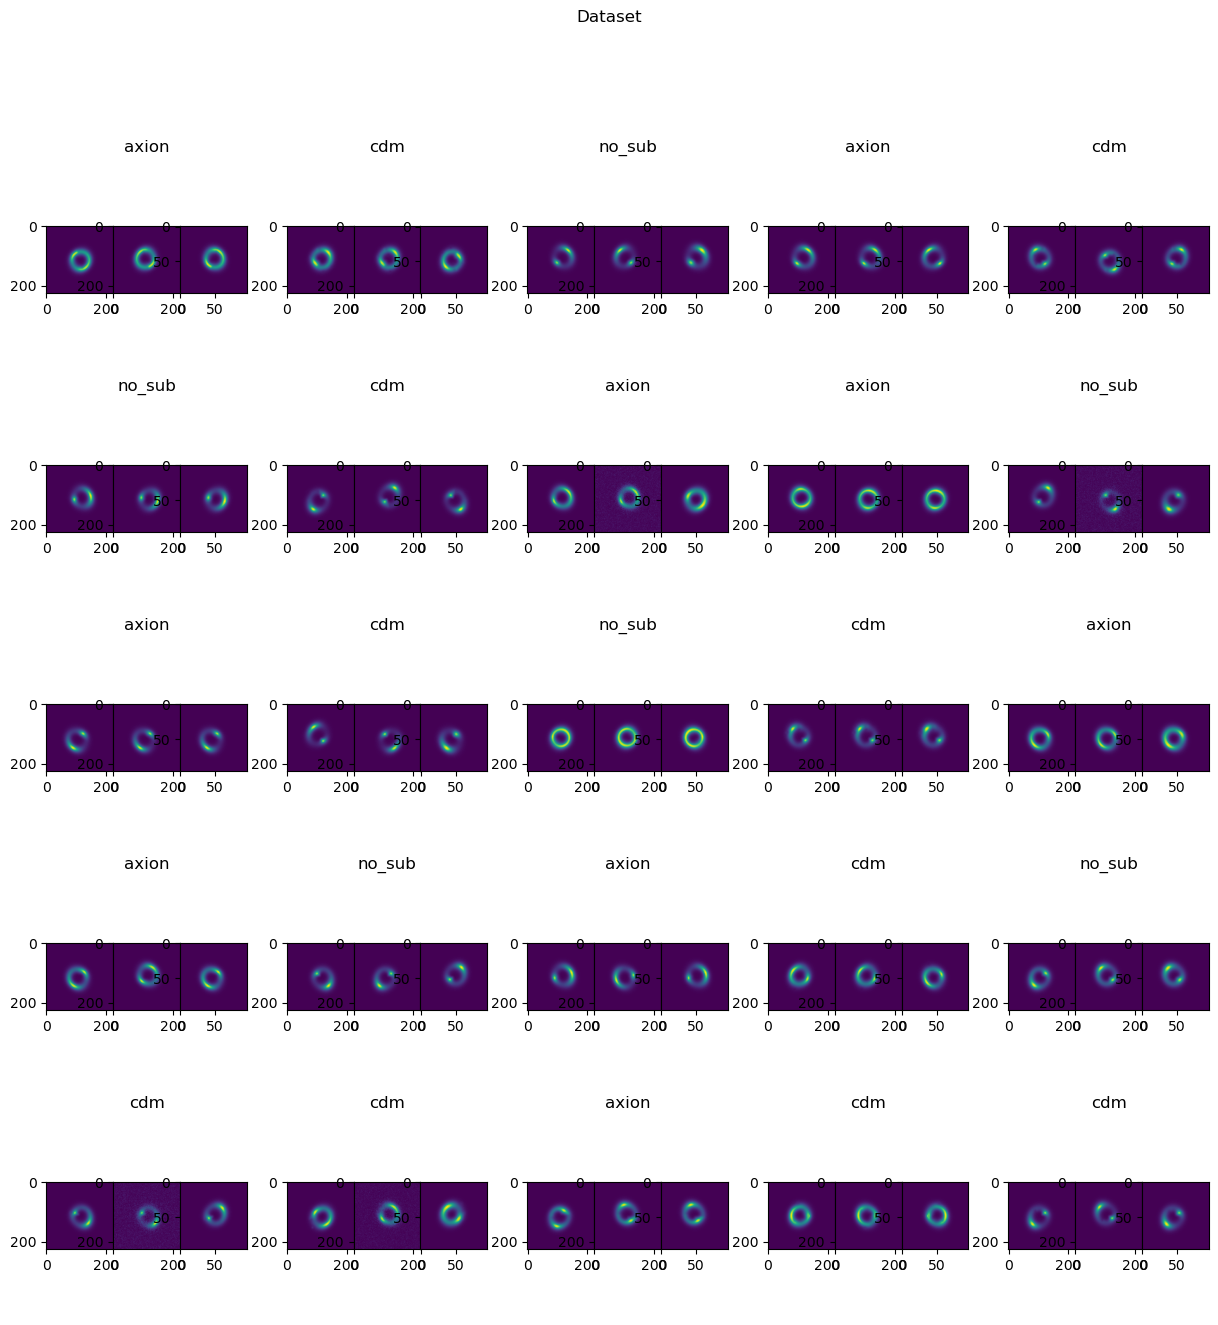

In [22]:
from utils.dataset import visualize_samples_ssl, DeepLenseDatasetSSL
# trainset
dino_transform = DINOTransform()
train_transforms = dino_transform.get_transforms()
train_dataset = DeepLenseDatasetSSL(destination_dir = dataset_dir, transforms = train_transforms, mode="train", dataset_name=dataset_name, download=True, channels=1)
print(f"train data: {len(train_dataset)}")
visualize_samples_ssl(train_dataset, labels_map=classes, num_rows_inner=1, num_cols_inner=3)

In [23]:
# split in train and valid set
split_ratio = 0.25  # 0.25
valid_len = int(split_ratio * len(train_dataset))
train_len = len(train_dataset) - valid_len

train_dataset, val_set = random_split(train_dataset, [train_len, valid_len])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

val_loader = DataLoader(
    dataset=val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

# Load test dataset
# testset = default_dataset_setup.get_dataset(mode="val")
# test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)

# size check
sample = next(iter(train_loader))
print("num of classes: ", num_classes)
print(sample[0].shape)

num of classes:  3
torch.Size([64, 1, 224, 224])


In [24]:
from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.dino_transform import DINOTransform
from lightly.utils.scheduler import cosine_schedule

In [25]:
class DINO(torch.nn.Module):
    def __init__(self, backbone, input_dim):
        super().__init__()

        self.backbone = backbone
        self.backbone[0] = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        self.student_backbone = self.backbone
        self.student_head = DINOProjectionHead(
            input_dim, 512, 64, 2048, freeze_last_layer=1
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)

    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

In [26]:
class DINOTransformer(torch.nn.Module):
    def __init__(self, backbone, input_dim):
        super().__init__()

        self.backbone = backbone
        self.student_backbone = self.backbone
        self.student_head = DINOProjectionHead(
            input_dim, 512, 64, 512, freeze_last_layer=1
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 512)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)

    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

In [27]:
# # Create ResNet pretrain model
# resnet = torchvision.models.resnet34()
# backbone = nn.Sequential(*list(resnet.children())[:-1])

num_ftrs_dict = {
    "resnet18": 512,
    "resnet34": 512,
    "resnet50": 2048,

}

# model =  DINO(backbone, input_dim=num_ftrs_dict["resnet34"])
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# summary(model, input_size=(2, 1, 224, 224), device="cuda")

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
network_config = {
    "s1_emb_dim": 64,  # stage 1 - dimension
    "s1_emb_kernel": 7,  # stage 1 - conv kernel size
    "s1_emb_stride": 4,  # stage 1 - conv stride
    "s1_proj_kernel": 3,  # stage 1 - attention ds-conv kernel size
    "s1_kv_proj_stride": 2,  # stage 1 - attention key / value projection stride
    "s1_heads": 2,  # stage 1 - heads
    "s1_depth": 2,  # stage 1 - depth
    "s1_mlp_mult": 3,  # stage 1 - feedforward expansion factor
    "s2_emb_dim": 128,  # stage 2 - (same as above)
    "s2_emb_kernel": 3,
    "s2_emb_stride": 2,
    "s2_proj_kernel": 3,
    "s2_kv_proj_stride": 2,
    "s2_heads": 2,
    "s2_depth": 2,
    "s2_mlp_mult": 3,
    "mlp_last": 256,
    "dropout": 0.1,
}

In [30]:
in_features = 128
# Transformer model
backbone = TransformerModels(
    transformer_type=train_config["network_type"],
    num_channels=train_config["channels"],
    num_classes=in_features,
    img_size=image_size,
    **network_config, # **train_config["network_config"]
)


model = DINOTransformer(backbone, input_dim=in_features)
summary(model, input_size=(2, 1, 224, 224), device="cuda")

Layer (type:depth-idx)                                                      Output Shape              Param #
DINOTransformer                                                             [2, 512]                  992,960
├─CvT: 1-1                                                                  [2, 128]                  --
│    └─Sequential: 2-1                                                      [2, 128]                  --
│    │    └─Sequential: 3-1                                                 [2, 64, 56, 56]           121,984
│    │    └─Sequential: 3-2                                                 [2, 128, 28, 28]          409,728
│    │    └─AdaptiveAvgPool2d: 3-3                                          [2, 128, 1, 1]            --
│    │    └─Rearrange: 3-4                                                  [2, 128]                  --
│    │    └─Linear: 3-5                                                     [2, 256]                  33,024
│    │    └─BatchNorm1d: 3-6   

In [31]:
epochs_pretrain = 15

In [31]:
#optimizer
optimizer_pretrain = optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-4)
warmup_epochs = 3
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps= num_train_steps * warmup_epochs
num_training_steps=int(num_train_steps * epochs_pretrain)

#learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(optimizer_pretrain,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

In [ ]:
criterion_pretrain = DINOLoss(
    output_dim=512,
    warmup_teacher_temp_epochs=5,
)
# move loss to correct device because it also contains parameters
criterion_pretrain = criterion_pretrain.to(device)

In [ ]:
import logging

In [ ]:
print("Starting Training")
for epoch in range(epochs_pretrain):
    total_loss = 0
    best_loss = float("inf")

    momentum_val = cosine_schedule(epoch, epochs_pretrain, 0.996, 1)
    for batch_idx, batch in enumerate(train_loader):
        views = batch[:3]
        
        update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
        update_momentum(model.student_head, model.teacher_head, m=momentum_val)
        views = [view.to(device) for view in views]
        global_views = views[:2]
        teacher_out = [model.forward_teacher(view) for view in global_views]
        student_out = [model.forward(view) for view in views]
        loss = criterion_pretrain(teacher_out, student_out, epoch=epoch)
        total_loss += loss.detach()
        loss.backward()
        # We only cancel gradients of student head.
        model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
        optimizer_pretrain.step()
        optimizer_pretrain.zero_grad()
        cosine_scheduler.step()
            
        if batch_idx % 10 == 0:
            logging.debug(f"Epoch [{epoch}/{epochs_pretrain}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}")
            print(
                f"Epoch [{epoch}/{epochs_pretrain}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}"
            )

    if total_loss < best_loss:
        best_loss = total_loss

        torch.save(model.state_dict(), model_path_pretrained)

    avg_loss = total_loss / len(train_loader)
    
    logging.debug(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [32]:
class FinetuneClassifier(nn.Module):
    def __init__(self, backbone, head):
        super(FinetuneClassifier, self).__init__()
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.rearrange = Rearrange("... () () -> ...")
        self.head = head

    def forward(self, x):
        z = self.backbone(x)
        z = self.pool(z)
        z = self.rearrange(z)
        z = self.head(z)
        return z

In [33]:
# del model
# import gc
# gc.collect()
# torch.cuda.empty_cache()
# print(torch.cuda.memory_allocated())

In [33]:
model_path_pretrained

'/kaggle/working/logger/2023-08-09-21-09-16/checkpoint/CvT_pretrained_Model_II_2023-08-09-21-09-16.pt'

In [34]:
# load model
model =  DINOTransformer(backbone, input_dim=128) # num_ftrs_dict["resnet34"]
model.load_state_dict(torch.load(model_path_pretrained))
summary(model, input_size=(2, 1, 224, 224), device="cuda")

Layer (type:depth-idx)                                                      Output Shape              Param #
DINOTransformer                                                             [2, 512]                  992,960
├─CvT: 1-1                                                                  [2, 128]                  --
│    └─Sequential: 2-1                                                      [2, 128]                  --
│    │    └─Sequential: 3-1                                                 [2, 64, 56, 56]           121,984
│    │    └─Sequential: 3-2                                                 [2, 128, 28, 28]          409,728
│    │    └─AdaptiveAvgPool2d: 3-3                                          [2, 128, 1, 1]            --
│    │    └─Rearrange: 3-4                                                  [2, 128]                  --
│    │    └─Linear: 3-5                                                     [2, 256]                  33,024
│    │    └─BatchNorm1d: 3-6   

In [35]:
class FinetuneClassifierTransformer(nn.Module):
    def __init__(self, backbone, head):
        super(FinetuneClassifierTransformer, self).__init__()
        self.backbone = backbone
        # self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        # self.rearrange = Rearrange("... () () -> ...")
        self.head = head

    def forward(self, x):
        z = self.backbone(x)
        # z = self.pool(z)
        # z = self.rearrange(z)
        z = self.head(z)
        return z

In [36]:
backbone = model.student_backbone # nn.Sequential(*list(model.backbone.children())[:-1])
model.student_head
backbone = nn.Sequential(model.student_backbone, model.student_head)

In [37]:
classification_head = nn.Sequential(
    nn.Linear(512, 512), # num_ftrs_dict["resnet34"]
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, num_classes),)
finetune_model = FinetuneClassifierTransformer(backbone, classification_head)
finetune_model.to(device)
summary(finetune_model, input_size=(2, 1, 224, 224), device="cuda")

Layer (type:depth-idx)                                                           Output Shape              Param #
FinetuneClassifierTransformer                                                    [2, 3]                    --
├─Sequential: 1-1                                                                [2, 512]                  --
│    └─CvT: 2-1                                                                  [2, 128]                  --
│    │    └─Sequential: 3-1                                                      [2, 128]                  598,144
│    └─DINOProjectionHead: 2-2                                                   [2, 512]                  --
│    │    └─Sequential: 3-2                                                      [2, 64]                   361,536
│    │    └─Linear: 3-3                                                          [2, 512]                  33,280
├─Sequential: 1-2                                                                [2, 3]              

In [56]:
import math
learning_rate = 3e-4 # 3e-4
weight_decay =  0.01

finetune_optimizer = optim.AdamW(
    finetune_model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

finetune_epochs = 20

#optimizer
optimizer_finetune = optim.AdamW(finetune_model.parameters(), lr=learning_rate) #  weight_decay = 1e-4
warmup_epochs = 3
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps= num_train_steps * warmup_epochs
num_training_steps=int(num_train_steps * finetune_epochs)

#learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(optimizer_finetune,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

In [57]:
finetune_criterion = nn.CrossEntropyLoss()

In [58]:
def finetune(
    epochs: int,
    model: nn.Module,
    device: Union[int, str],
    train_loader: Any,
    criterion: nn.Module,
    optimizer: nn.Module,
    saved_model_path: str,
    valid_loader: Any,
):
    best_loss = float("inf")
    best_accuracy = float("-inf")
    all_val_loss = []
    all_val_accuracy = []

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()

        for batch_idx, batch in enumerate(train_loader): # for batch_idx, batch in enumerate(train_loader):
            img1 = batch[0].to(device)
            label = batch[-1].to(device)
            optimizer.zero_grad()
            output = model(img1)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            # cosine_scheduler.step()
            epoch_loss += loss

            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}"
                )

        epoch_loss = epoch_loss / len(train_loader)

        with torch.no_grad():
            print("====== Eval started ======")
            model.eval()
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for batch_idx, batch in enumerate(valid_loader): # for batch_idx, batch in enumerate(train_loader):
                data = batch[0].to(device)
                label = batch[-1].to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc
                epoch_val_loss += val_loss

            epoch_val_accuracy = epoch_val_accuracy / len(valid_loader)
            
            if epoch_val_accuracy > best_accuracy:
                best_accuracy = epoch_val_accuracy
                best_model_state = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), saved_model_path)
                print("====== Model saved ======")
            
            epoch_val_loss = epoch_val_loss / len(valid_loader)
            all_val_loss.append(epoch_val_loss)

        all_val_accuracy.append(epoch_val_accuracy.item() * 100)

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} \n"
        )

In [59]:
# Training loop
finetune(
    finetune_epochs,
    finetune_model,
    device,
    train_loader,
    finetune_criterion,
    finetune_optimizer,
    finetuned_model_path,
    valid_loader=val_loader,
)

Epoch [0/15], Batch [0/1045], Loss: 0.1274917870759964
Epoch [0/15], Batch [100/1045], Loss: 0.08781257271766663
Epoch [0/15], Batch [200/1045], Loss: 0.025529002770781517
Epoch [0/15], Batch [300/1045], Loss: 0.06417783349752426
Epoch [0/15], Batch [400/1045], Loss: 0.04331492260098457
Epoch [0/15], Batch [500/1045], Loss: 0.11023607105016708
Epoch [0/15], Batch [600/1045], Loss: 0.08123549818992615
Epoch [0/15], Batch [700/1045], Loss: 0.08255978673696518
Epoch [0/15], Batch [800/1045], Loss: 0.2023857682943344
Epoch [0/15], Batch [900/1045], Loss: 0.11167694628238678
Epoch [0/15], Batch [1000/1045], Loss: 0.051038000732660294
====== Model saved ======
====== Eval started ======
Epoch : 1 - loss : 0.1192 - val_loss : 30.6020 - val_acc: 0.3365 

Epoch [1/15], Batch [0/1045], Loss: 0.15301254391670227
Epoch [1/15], Batch [100/1045], Loss: 0.10386929661035538
Epoch [1/15], Batch [200/1045], Loss: 0.14956945180892944
Epoch [1/15], Batch [300/1045], Loss: 0.18057814240455627
Epoch [1/15],

In [45]:
test_dataset_dir = "/kaggle/input/gsocml4scimodel2test"
test_dataset = DeepLenseDatasetSSL(destination_dir = test_dataset_dir, transforms = train_transforms, mode="test", dataset_name=dataset_name, download=True, channels=1)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

Model_II dataset already exists


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [46]:
finetuned_model_path = "/kaggle/working/logger/2023-08-09-21-09-16/checkpoint/CvT_dino_finetuned_Model_II_2023-08-11-06-52-23.pt"
finetune_model.load_state_dict(torch.load(finetuned_model_path)) # 

<All keys matched successfully>

Inference started ...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<Figure size 640x480 with 0 Axes>

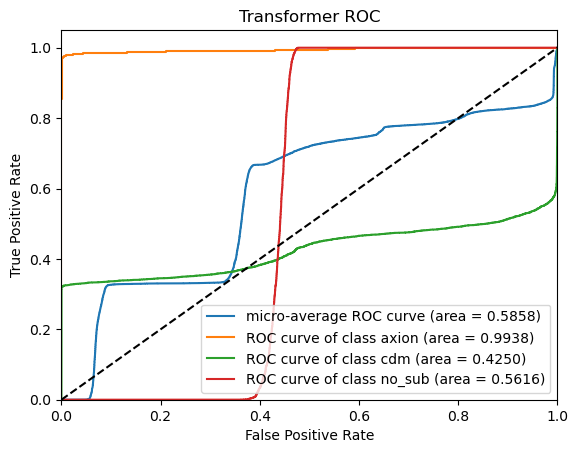

Confusion matrix, without normalization


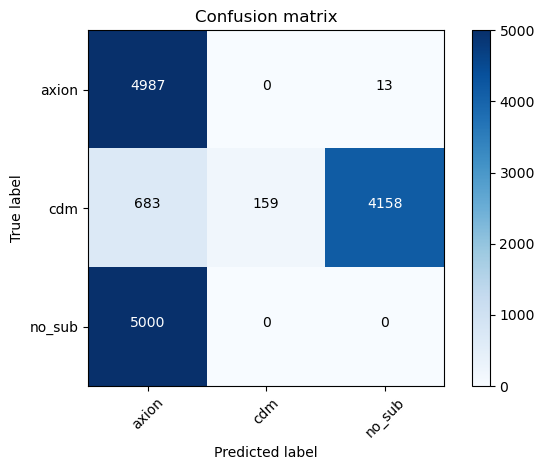

In [47]:
channels = 1
infer_obj = InferenceSSL(
    finetune_model,
    test_loader,
    device,
    num_classes,
    test_dataset,
    dataset_name,
    labels_map=classes, # classes
    image_size=image_size,
    channels=channels,
    destination_dir="data",
    log_dir=log_dir,  # log_dir
)

infer_obj.infer_plot_roc()
infer_obj.generate_plot_confusion_matrix()